# **Identifying Nutrient Deficiencies in Satellite Farmland Imagery**
## 02A: U-Net: RGB Channels Only

I certainly did not conceive of the U-Net implementation in this notebook on my own. Credit is due to Harshall Lambda, and I'm citing his blog and U-Net notebook as sources of inspiration below:  
[Towards Data Science article](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)  
[U-Net Notebook (github)](https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb)


---


## Google Colab UNET Model Training Workbook (RGB channels only)

This notebook was run **entirely in Google Colab** and may not work in Jupyter without some major modifications. It was run in Colab to take advantage of the GPU runtime.

For this notebook to work in Colab, you'll also need the requisite image data. Details for retrieving, selecting, and uploading the requisite image data are contained in [Data Retrieval and Model Training Setup](../Data_Retrieval_and_Model_Training_Setup.md).

In [1]:
# colab-specific tasks:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
"""
In order for this notebook to be runnable in Colab, you need
to upload the following files into a directory, and point
the `os.chdir()` call below to that directory.

The output of the `os.listdir()` call should include 
the following files:

[
  'image_metadata_with_clusters.csv',
  'features.zip',
  'labels.zip',
  'nir_features.zip',
  'output'   ### OUTPUT directory should be blank
]

The `output` directory is where best model weights will be
saved for later downloading.
"""

import os 
#make sure the path variable ends with a /
gdrive_path = '### REPLACE WITH YOUR GOOGLE DRIVE FILEPATH ###'
os.chdir(gdrive_path)
os.listdir()

['features',
 'labels',
 'output',
 'image_metatdata_with_clusters.csv',
 'nir_features',
 'features.zip',
 'labels.zip',
 'nir_features.zip']

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
np.random.seed(42)

#some image processing modules:
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

#some tensorflow.keras modules:
from tensorflow import math as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:
#set parameters:
im_width, im_height, input_channels = (128,128, 3)

In [5]:
#import metadata for image names:
df = pd.read_csv('image_metadata_with_clusters.csv')

In [6]:
#get image ids
ids = [x+'.jpg' for x in df['image_name']]

In [7]:
print('No. of images: ', len(ids))

No. of images:  14712


In [ ]:
"""
NOTE:
The commands below in Colab extract the images in the compressed
.zip files to the *root* `/content` directory 
**of your CURRENT COLAB RUNTIME**.

This is a **massive** performance improvement over keeping the
uncompressed image files in Google Drive and loading each one
into the Colab environment individually
(I learned this from experience).
"""

#unzips images to /content in colab environment
!unzip 'labels.zip' -d '/content'
!unzip 'features.zip' -d '/content'

In [9]:
X = np.zeros((len(ids), im_height, im_width, input_channels), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [10]:
for n, id_ in enumerate(ids):
    #load images
    x_img = img_to_array(load_img('/content/features/'+id_,color_mode='rgb'))
    x_img = resize(x_img, (im_width,im_height,3), mode='constant',preserve_range=True)

    #load masks:
    mask = img_to_array(load_img('/content/labels/'+id_.replace('.jpg','.png'),color_mode='grayscale'))
    mask = resize(mask,(im_width,im_height,1), mode='constant',preserve_range=True)
    #save and scale them:
    X[n] = x_img/255.0
    y[n] = mask/255.0
    
del x_img
del mask

In [11]:
print(f'shape of X: {X.shape}')
print(f'shape of y: {y.shape}')

shape of X: (14712, 128, 128, 3)
shape of y: (14712, 128, 128, 1)


In [12]:
test_size = 0.1 #90/10 train/val split
split = int(len(X)*(1-test_size))
X_train, X_valid = X[:split], X[split:]
y_train, y_valid = y[:split], y[split:]

In [13]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((13240, 128, 128, 3),
 (1472, 128, 128, 3),
 (13240, 128, 128, 1),
 (1472, 128, 128, 1))

In [14]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [15]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

The keras implementation of the Jaccard Coeffient and Loss below were inspired by YouTuber [DigitalSreeni](https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w), specifically their video titled ['Using IoU (Jaccard) as loss function to train U-Net for semantic segmentation'](https://www.youtube.com/watch?v=BNPW1mYbgS4).

In [16]:
from tensorflow.keras import backend as K
#custom intersection over union loss function:
def jaccard_coef(y_true, y_pred):
    """
    Arguments:
        y_true : Matrix containing one-hot encoded class labels 
                 with the last axis being the number of classes.
        y_pred : Matrix with same dimensions as y_true.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true,y_pred):
    return -jaccard_coef(y_true,y_pred)

In [17]:
input_img = Input((im_height, im_width, input_channels), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.10, batchnorm=True)
model.compile(optimizer=Adam(), loss=[jaccard_coef_loss], metrics=[jaccard_coef,"accuracy"])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [19]:
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.00001, verbose=1),
    ModelCheckpoint('output/rgb_nutrient_deficiency_identifier_JACCARD.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [20]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/100
414/414 [==============================] - ETA: 0s - loss: -0.3334 - jaccard_coef: 0.3335 - accuracy: 0.3884
Epoch 00001: val_loss improved from inf to -0.37667, saving model to output/rgb_nutrient_deficiency_identifier_JACCARD.h5
414/414 [==============================] - 29s 43ms/step - loss: -0.3334 - jaccard_coef: 0.3335 - accuracy: 0.3884 - val_loss: -0.3767 - val_jaccard_coef: 0.3767 - val_accuracy: 0.3921 - lr: 0.0010
Epoch 2/100
413/414 [============================>.] - ETA: 0s - loss: -0.3607 - jaccard_coef: 0.3607 - accuracy: 0.3968
Epoch 00002: val_loss improved from -0.37667 to -0.38653, saving model to output/rgb_nutrient_deficiency_identifier_JACCARD.h5
414/414 [==============================] - 17s 42ms/step - loss: -0.3606 - jaccard_coef: 0.3605 - accuracy: 0.3967 - val_loss: -0.3865 - val_jaccard_coef: 0.3865 - val_accuracy: 0.4180 - lr: 0.0010
Epoch 3/100
413/414 [============================>.] - ETA: 0s - loss: -0.3647 - jaccard_coef: 0.3647 - accuracy:

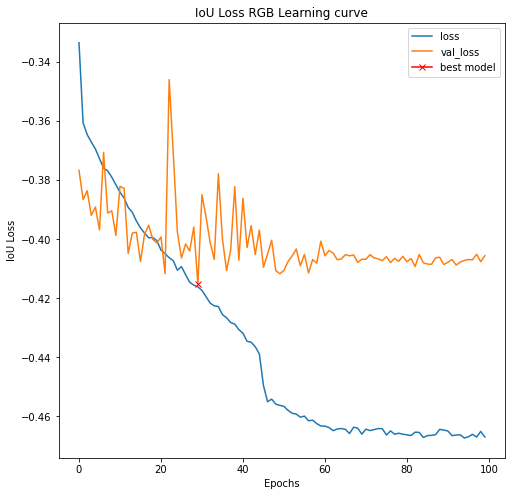

In [25]:
plt.figure(figsize=(8, 8))
plt.title("IoU Loss RGB Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("IoU Loss")
plt.legend()
#plt.savefig('output/IoU_RGB_LearningCurve.png');

In [22]:
model.evaluate(X_valid,y_valid)

46/46 [==============================] - 1s 13ms/step - loss: -0.4056 - jaccard_coef: 0.4056 - accuracy: 0.6219


[-0.40555447340011597, 0.40555447340011597, 0.6219240427017212]

---

Train a second model using BCE Loss rather than Jaccard (IoU) Loss:

In [31]:
input_img = Input((im_height, im_width, input_channels), name='img')
bce_model = get_unet(input_img, n_filters=16, dropout=0.10, batchnorm=True)
bce_model.compile(optimizer=Adam(), loss=['binary_crossentropy'], metrics=[jaccard_coef,"accuracy"])
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.00001, verbose=1),
    ModelCheckpoint('output/rgb_nutrient_deficiency_identifier_BCE.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

bce_results = bce_model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

414/414 [==============================] - ETA: 0s - loss: 0.6356 - jaccard_coef: 0.2282 - accuracy: 0.6267
Epoch 00001: val_loss improved from inf to 0.63967, saving model to output/rgb_nutrient_deficiency_identifier_BCE.h5
414/414 [==============================] - 55s 43ms/step - loss: 0.6356 - jaccard_coef: 0.2282 - accuracy: 0.6267 - val_loss: 0.6397 - val_jaccard_coef: 0.2401 - val_accuracy: 0.6147 - lr: 0.0010
Epoch 2/100
413/414 [============================>.] - ETA: 0s - loss: 0.6179 - jaccard_coef: 0.2398 - accuracy: 0.6424
Epoch 00002: val_loss improved from 0.63967 to 0.63487, saving model to output/rgb_nutrient_deficiency_identifier_BCE.h5
414/414 [==============================] - 17s 42ms/step - loss: 0.6179 - jaccard_coef: 0.2398 - accuracy: 0.6424 - val_loss: 0.6349 - val_jaccard_coef: 0.2665 - val_accuracy: 0.6182 - lr: 0.0010
Epoch 3/100
414/414 [==============================] - ETA: 0s - loss: 0.6095 - jaccard_coef: 0.2483 - accuracy: 0.6482
Epoch 00003: val_loss 

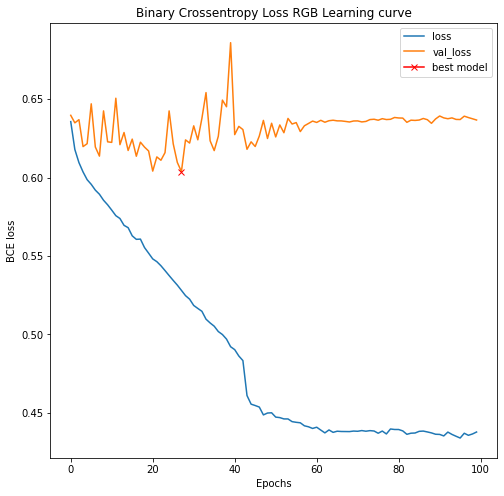

In [32]:
plt.figure(figsize=(8, 8))
plt.title("Binary Crossentropy Loss RGB Learning curve")
plt.plot(bce_results.history["loss"], label="loss")
plt.plot(bce_results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(bce_results.history["val_loss"]), np.min(bce_results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("BCE loss")
plt.legend()
#plt.savefig('output/BCE_RGB_LearningCurve.png');

In [33]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
